In [1]:
import json
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [2]:
FILE_PATH = '/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5'
JSON_PATH = '/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/classes-fixed.json'

In [3]:
with open(JSON_PATH, 'r') as f:
    fixed_classes = json.load(f)

print(f"Found {len(fixed_classes)} modulations:\n", fixed_classes)

Found 24 modulations:
 ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


In [4]:
with h5py.File(FILE_PATH, 'r') as f:
    Y_arr = f['Y'][:]            # shape (2 555 904, 24)
    Z_arr = f['Z'][:].flatten()  # shape (2 555 904,)

print("Y_arr shape:", Y_arr.shape)
print("Z_arr shape:", Z_arr.shape)

Y_arr shape: (2555904, 24)
Z_arr shape: (2555904,)


In [5]:
unique_snrs = np.unique(Z_arr)
print("Available SNR levels (dB):", unique_snrs)

Available SNR levels (dB): [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]


In [6]:
def find_modulation_snr_indices(mod_name, snr_level, classes_fixed, Y_arr, Z_arr):
    """
    Return an array of sample-indices where:
      - the one-hot in Y_arr matches mod_name
      - the corresponding Z_arr == snr_level
    """
    mod_idx = classes_fixed.index(mod_name)
    mask = (np.argmax(Y_arr, axis=1) == mod_idx) & (Z_arr == snr_level)
    return np.nonzero(mask)[0]

In [7]:
def plot_signals_by_modulation_snr(mod_name, snr_level, num_samples, file_path, classes_fixed, Y_arr, Z_arr):
    # 1) find indices
    idxs = find_modulation_snr_indices(mod_name, snr_level, classes_fixed, Y_arr, Z_arr)
    if len(idxs) < num_samples:
        print(f"⚠️ Only found {len(idxs)} samples for {mod_name}@{snr_level} dB")
        return

    # 2) pick a few at random
    chosen = np.random.choice(idxs, num_samples, replace=False)

    # 3) re-open HDF5 and slice X for each sample
    with h5py.File(file_path, 'r') as f:
        X_ds = f['X']  # shape (N, 1024, 2)
        for samp in chosen:
            I = X_ds[samp, :, 0]
            Q = X_ds[samp, :, 1]
            M = np.sqrt(I**2 + Q**2)

            fig, axs = plt.subplots(1, 3, figsize=(15, 3))
            axs[0].plot(I); axs[0].set_title(f"{mod_name} I (SNR={snr_level}dB)")
            axs[1].plot(Q); axs[1].set_title(f"{mod_name} Q")
            axs[2].plot(M); axs[2].set_title("Magnitude")
            for ax in axs:
                ax.set_xlabel("Sample index")
            plt.tight_layout()
            plt.show()

In [8]:
with h5py.File(FILE_PATH, 'r') as f:
    Y_onehot = f['Y'][:]    # one-hot label array, shape (N_samples, N_mods)
    Z_arr     = f['Z'][:].flatten()  # SNRs

### 4ASK & 16QAM signal 

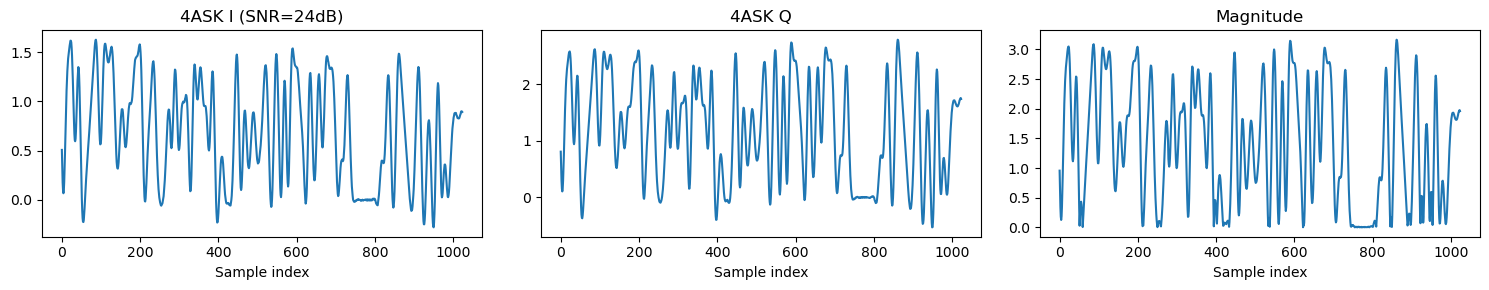

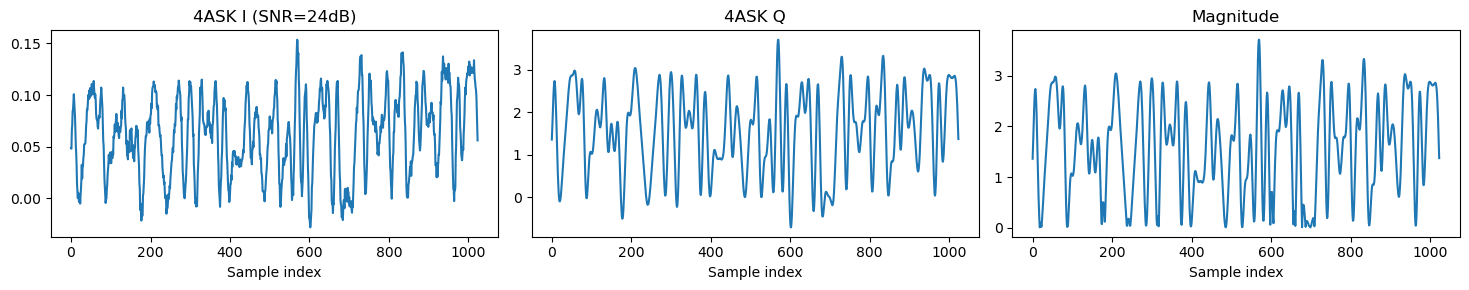

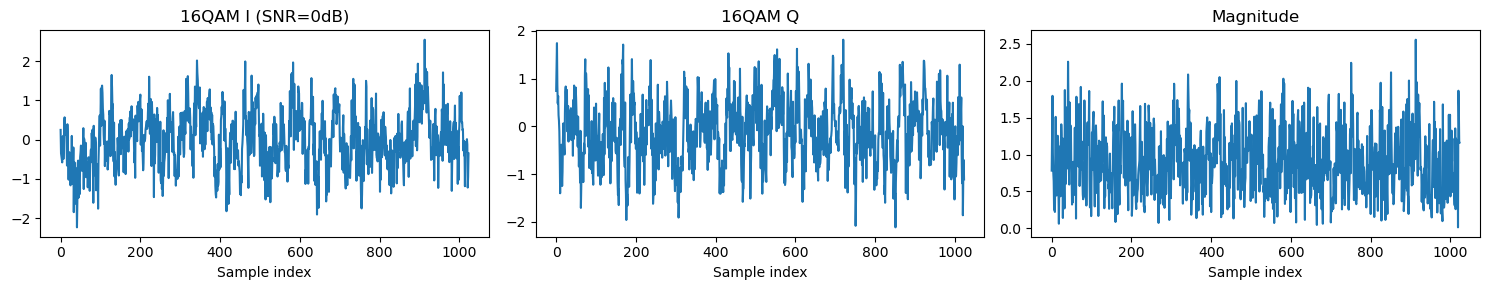

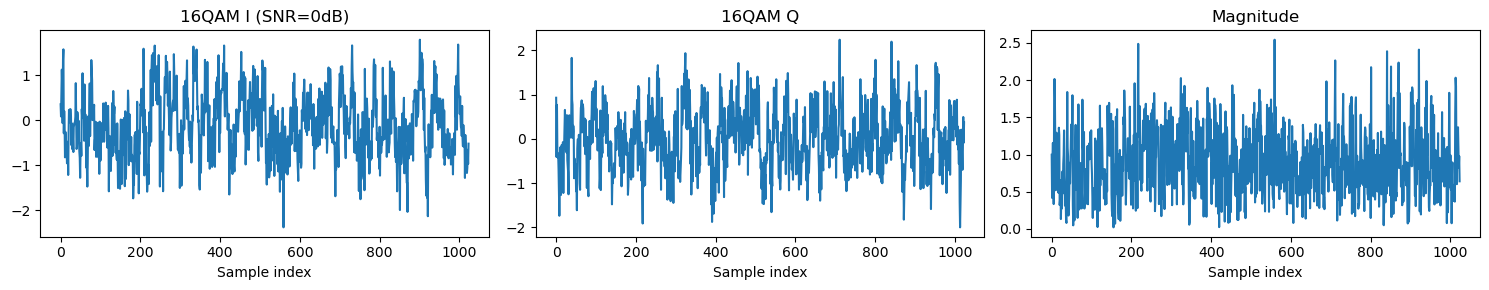

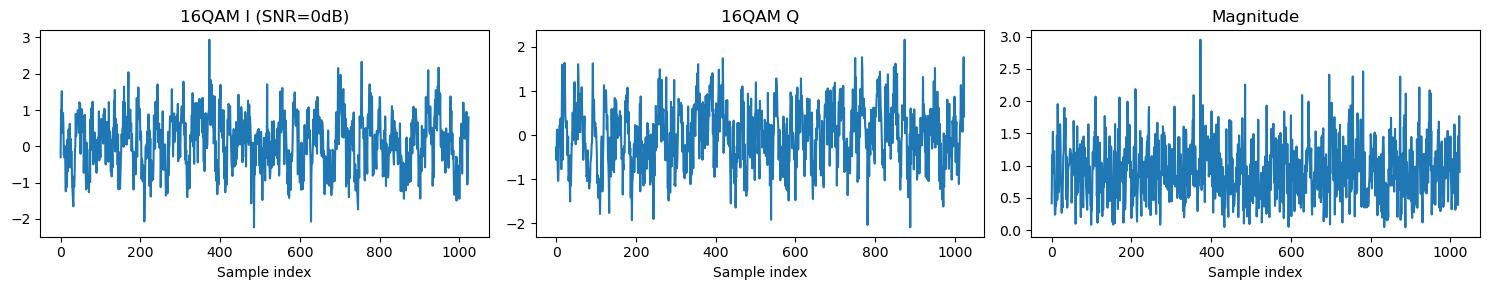

In [9]:
plot_signals_by_modulation_snr(
    mod_name='4ASK',
    snr_level=24,
    num_samples=2,
    file_path=FILE_PATH,
    classes_fixed=fixed_classes,
    Y_arr=Y_arr,
    Z_arr=Z_arr
)

# Plot 3 random 16QAM signals at 0 dB
plot_signals_by_modulation_snr(
    mod_name='16QAM',
    snr_level=0,
    num_samples=3,
    file_path=FILE_PATH,
    classes_fixed=fixed_classes,
    Y_arr=Y_arr,
    Z_arr=Z_arr
)

### OOK signal & 8ASK

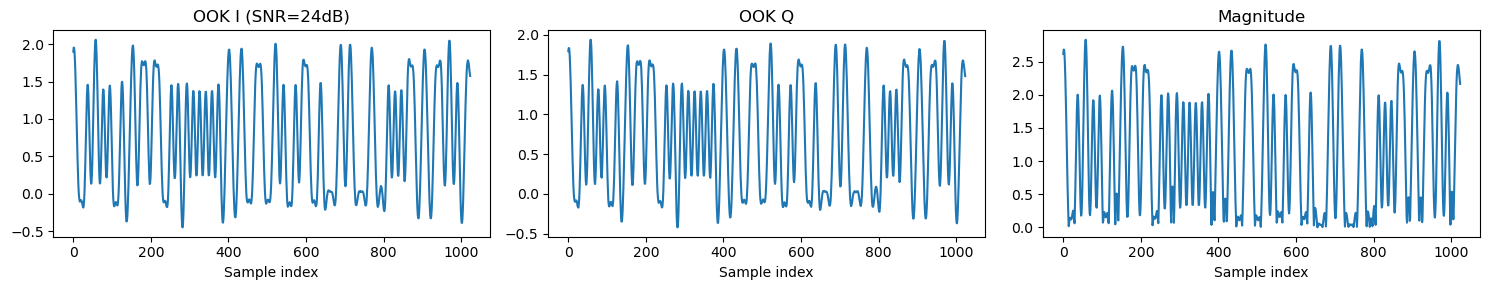

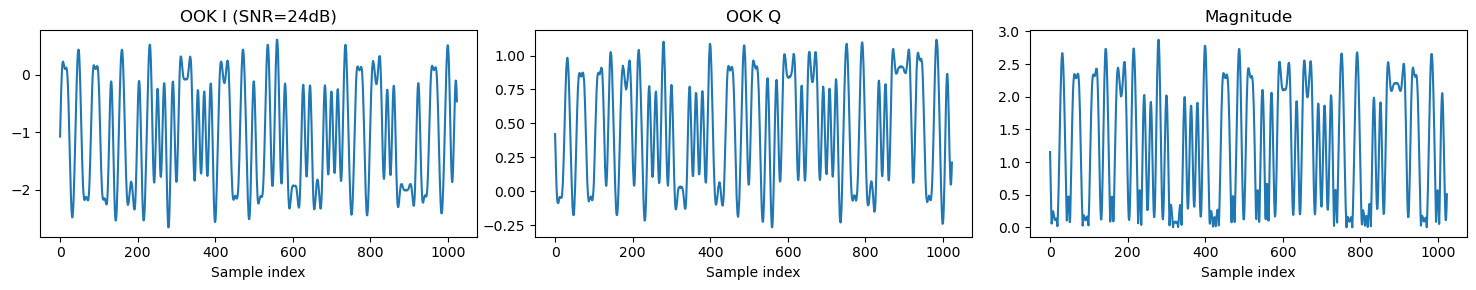

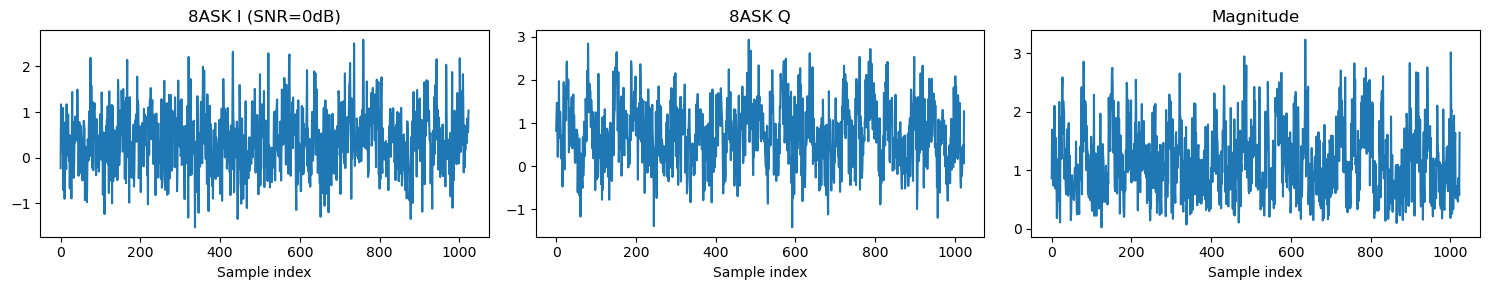

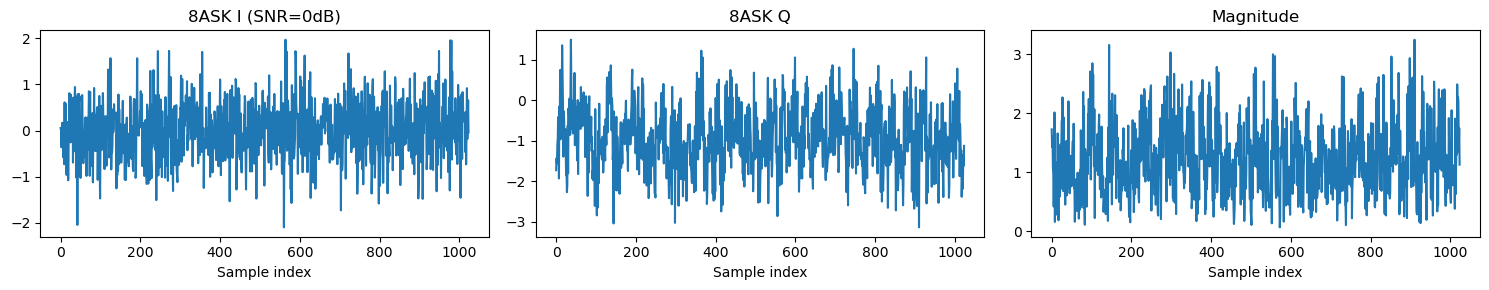

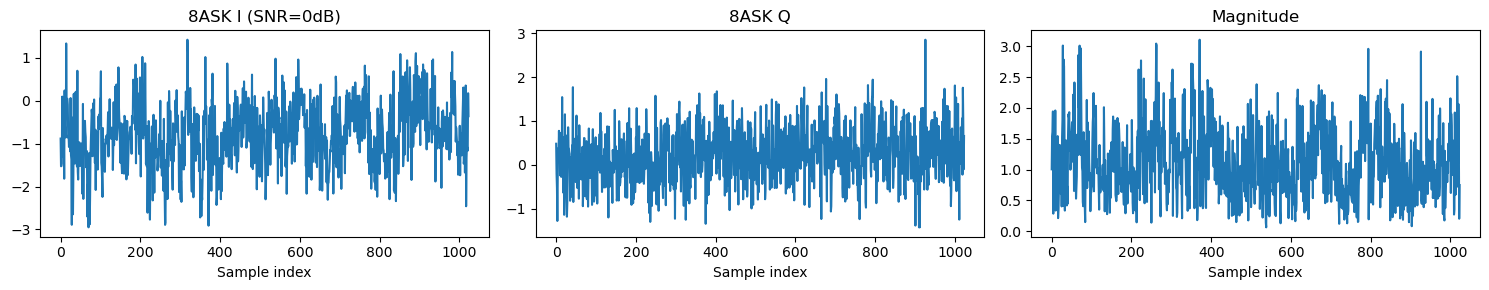

In [10]:
# ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
plot_signals_by_modulation_snr(
    mod_name='OOK',
    snr_level=24,
    num_samples=2,
    file_path=FILE_PATH,
    classes_fixed=fixed_classes,
    Y_arr=Y_arr,
    Z_arr=Z_arr
)

# Plot 3 random 16QAM signals at 0 dB
plot_signals_by_modulation_snr(
    mod_name='8ASK',
    snr_level=0,
    num_samples=3,
    file_path=FILE_PATH,
    classes_fixed=fixed_classes,
    Y_arr=Y_arr,
    Z_arr=Z_arr
)

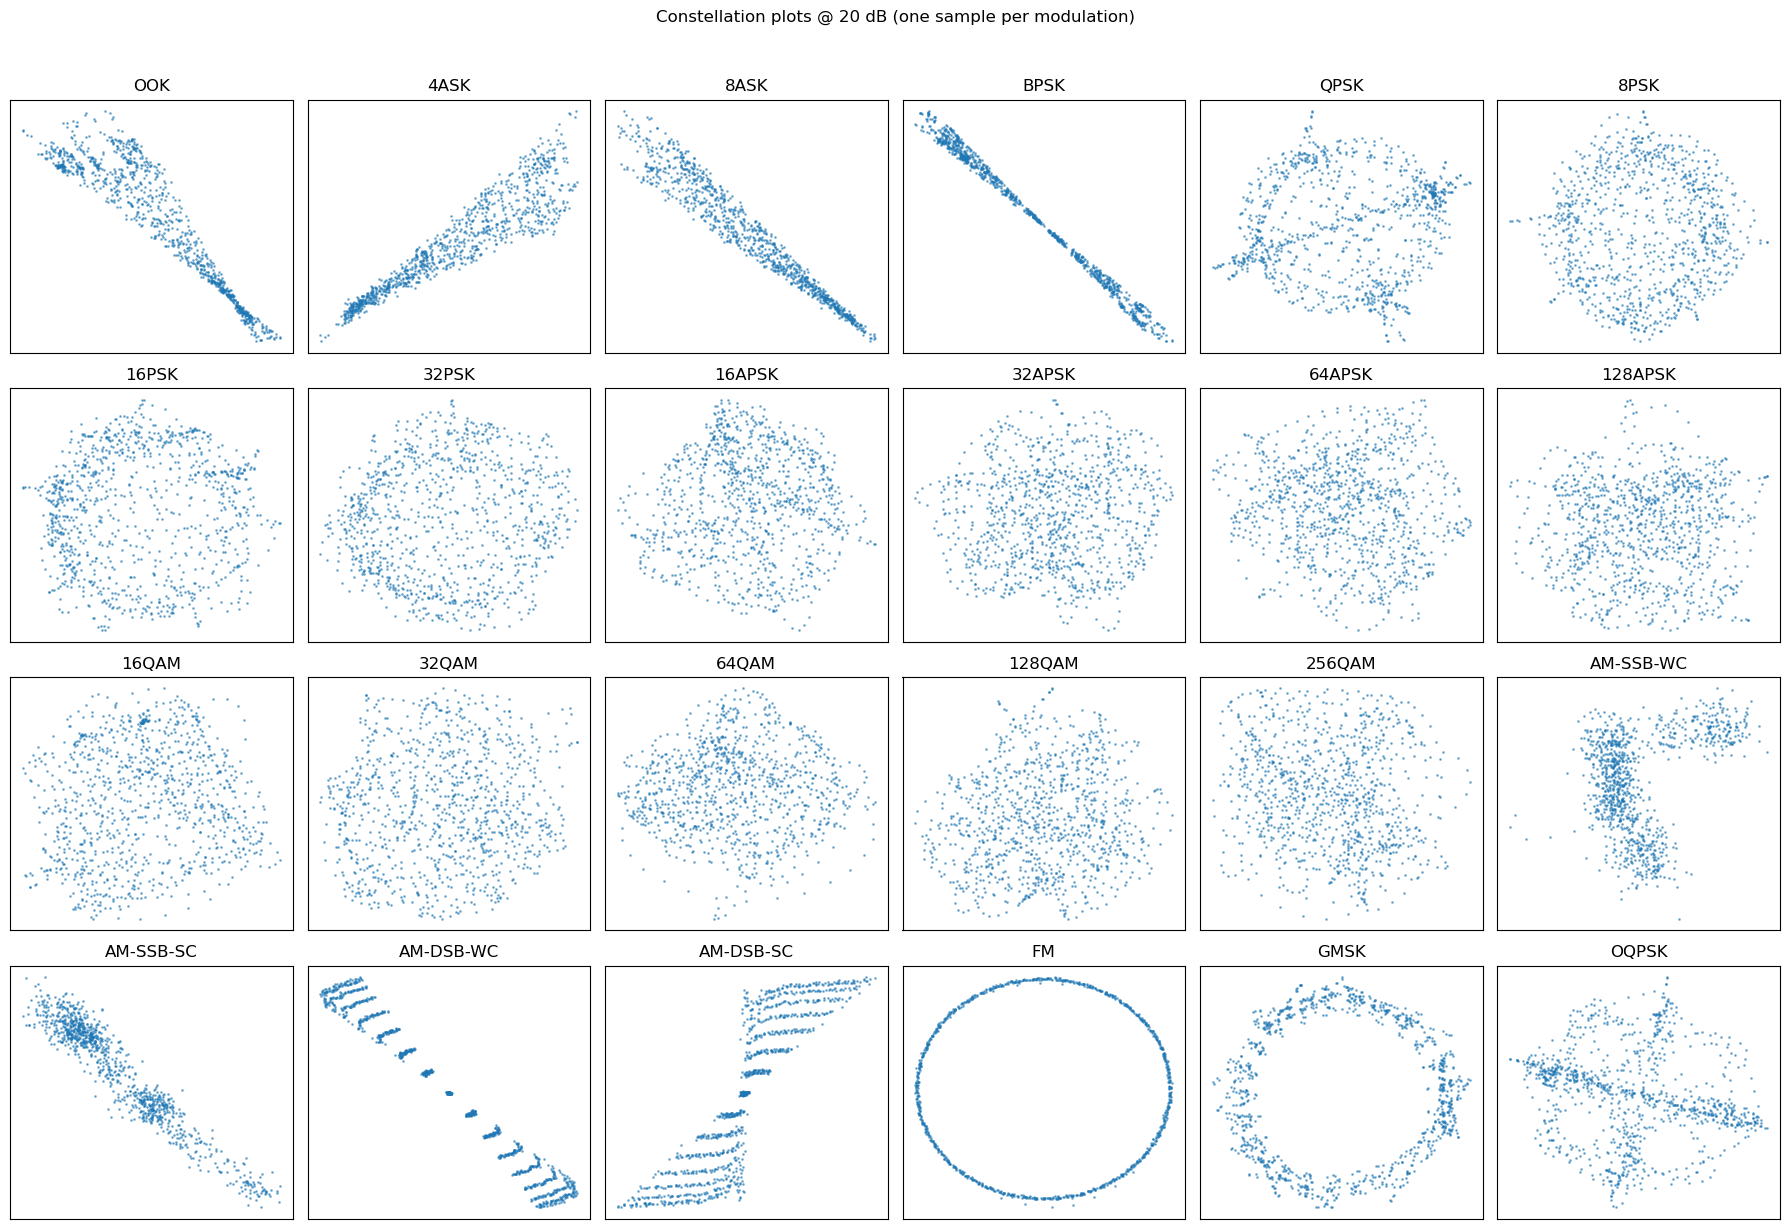

In [11]:
# %% [markdown]
# ## 7) Plot All Modulations at a Given SNR in a Grid

import math
import matplotlib.pyplot as plt

def plot_all_modulations_constellation(snr_level, fixed_classes, Y_arr, Z_arr, file_path, cols=6):
    """
    For each modulation in fixed_classes, pick the first sample at snr_level,
    and plot its I/Q constellation in a grid of `cols` columns.
    """
    # 1) find one sample index per modulation
    sample_idxs = {}
    for mod in fixed_classes:
        idxs = find_modulation_snr_indices(mod, snr_level, fixed_classes, Y_arr, Z_arr)
        if len(idxs):
            sample_idxs[mod] = idxs[0]
        else:
            sample_idxs[mod] = None

    n_mod = len(fixed_classes)
    rows = math.ceil(n_mod / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.flatten()

    # 2) open file once and plot each
    with h5py.File(file_path, 'r') as f:
        X_ds = f['X']
        for ax, mod in zip(axs, fixed_classes):
            idx = sample_idxs[mod]
            if idx is None:
                ax.text(0.5, 0.5, 'no samples', ha='center', va='center')
                ax.set_title(mod)
                ax.set_xticks([]); ax.set_yticks([])
                continue

            I = X_ds[idx, :, 0]
            Q = X_ds[idx, :, 1]
            ax.scatter(I, Q, s=1, alpha=0.5)
            ax.set_title(mod)
            ax.set_xticks([]); ax.set_yticks([])

    # 3) remove any extra axes
    for ax in axs[n_mod:]:
        fig.delaxes(ax)

    plt.suptitle(f"Constellation plots @ {snr_level} dB (one sample per modulation)", y=1.02)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ### Example: plot all 24 modulations at 0 dB
plot_all_modulations_constellation(
    snr_level=20,
    fixed_classes=fixed_classes,
    Y_arr=Y_arr,
    Z_arr=Z_arr,
    file_path=FILE_PATH,
    cols=6
)


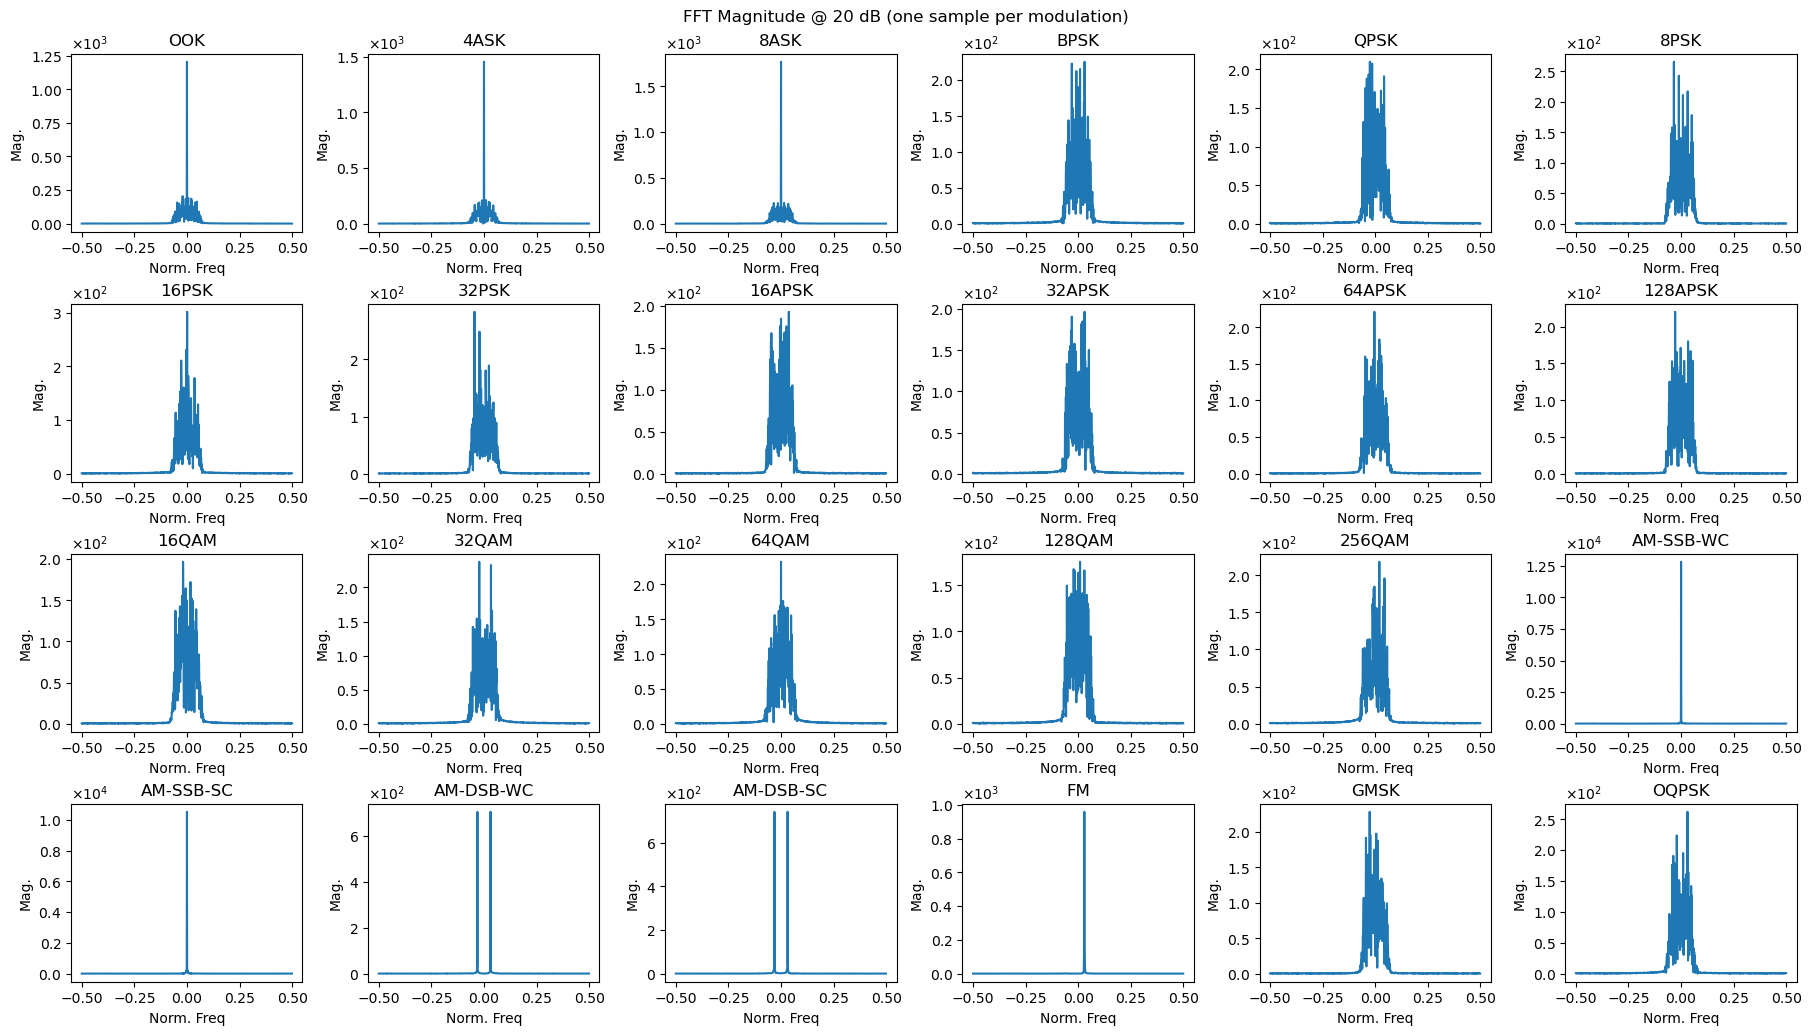

In [12]:
def plot_all_modulations_spectrum(snr_level, fixed_classes, Y_arr, Z_arr, file_path, cols=6):
    """
    For each modulation in fixed_classes:
      1) pick the first sample index at snr_level
      2) compute its FFT magnitude (shifted)
      3) plot FFT magnitude vs. normalized frequency
    """
    # 1) find one index per modulation
    sample_idxs = {}
    for mod in fixed_classes:
        idxs = np.nonzero((np.argmax(Y_arr, axis=1) == fixed_classes.index(mod)) & (Z_arr == snr_level))[0]
        sample_idxs[mod] = idxs[0] if idxs.size else None

    n_mod = len(fixed_classes)
    rows = math.ceil(n_mod / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5), constrained_layout=True)
    axs = axs.flatten()

    # 2) open file once and plot spectra
    with h5py.File(file_path, 'r') as f:
        X_ds = f['X']  # shape (N, 1024, 2)
        for ax, mod in zip(axs, fixed_classes):
            idx = sample_idxs[mod]
            if idx is None:
                ax.text(0.5,0.5,'no samples',ha='center',va='center')
                ax.set_title(mod)
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # build complex signal
            I = X_ds[idx, :, 0]
            Q = X_ds[idx, :, 1]
            sig = I + 1j*Q

            # FFT
            N = sig.size
            fft_vals = np.abs(np.fft.fftshift(np.fft.fft(sig)))
            freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1.0))  # normalized freq

            ax.plot(freqs, fft_vals)
            ax.set_title(mod)
            ax.set_xlabel('Norm. Freq')
            ax.set_ylabel('Mag.')
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

    # 3) remove any extra axes
    for ax in axs[n_mod:]:
        fig.delaxes(ax)

    plt.suptitle(f"FFT Magnitude @ {snr_level} dB (one sample per modulation)", y=1.02)
    plt.show()

# %% [markdown]
# ### Example: Plot all 24 modulations at 0 dB
plot_all_modulations_spectrum(
    snr_level=20,
    fixed_classes=fixed_classes,
    Y_arr=Y_arr,
    Z_arr=Z_arr,
    file_path=FILE_PATH,
    cols=6
)

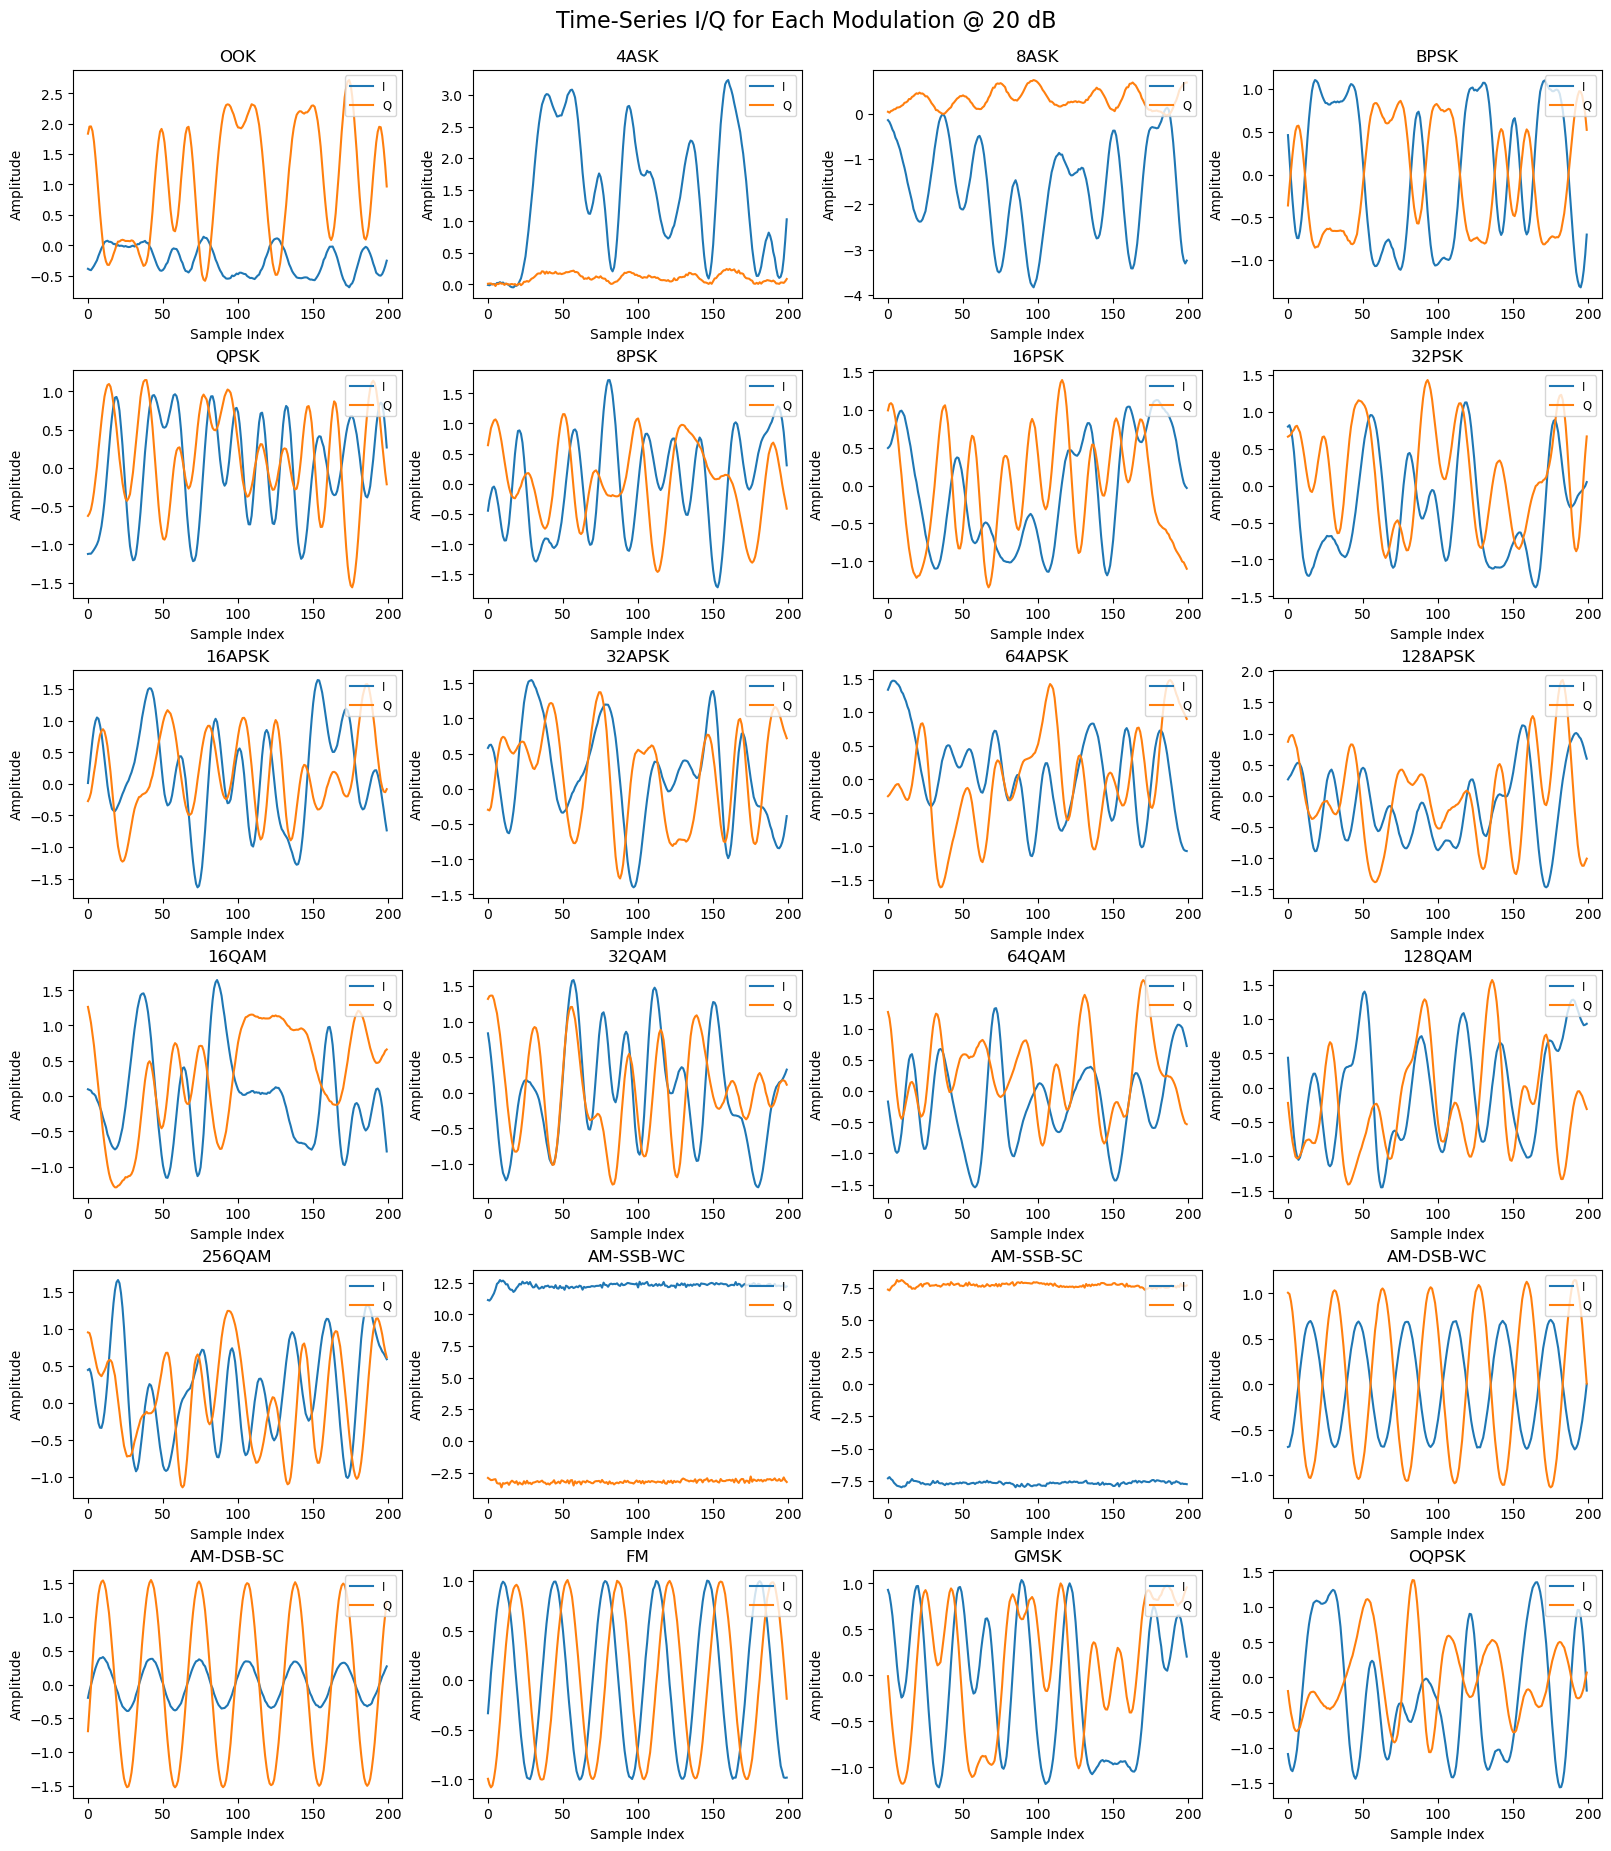

In [12]:
def  plot_all_modulations_timeseries(snr_level, fixed_classes, Y_arr, Z_arr, file_path, cols=4, t_len=200):
    """
    For each modulation in fixed_classes:
      1) pick the first sample index at snr_level
      2) plot its I and Q vs. time for the first t_len points
    """
    # 1) find one index per modulation
    sample_idxs = {}
    for mod in fixed_classes:
        mask = (np.argmax(Y_arr, axis=1) == fixed_classes.index(mod)) & (Z_arr == snr_level)
        idxs = np.nonzero(mask)[0]
        sample_idxs[mod] = idxs[0] if idxs.size else None

    n_mod = len(fixed_classes)
    rows = math.ceil(n_mod / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*3), constrained_layout=True)
    axs = axs.flatten()

    # 2) open file once and plot each time-series
    with h5py.File(file_path, 'r') as f:
        X_ds = f['X']
        for ax, mod in zip(axs, fixed_classes):
            idx = sample_idxs[mod]
            ax.set_title(mod)
            if idx is None:
                ax.text(0.5, 0.5, 'no samples', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
            else:
                I = X_ds[idx, :t_len, 0]
                Q = X_ds[idx, :t_len, 1]
                ax.plot(I, label='I')
                ax.plot(Q, label='Q')
                ax.set_xlabel('Sample Index')
                ax.set_ylabel('Amplitude')
                ax.legend(loc='upper right', fontsize='small')
    
    # 3) remove any extra axes
    for ax in axs[n_mod:]:
        fig.delaxes(ax)

    plt.suptitle(f"Time-Series I/Q for Each Modulation @ {snr_level} dB", y=1.02, fontsize=16)
    plt.show()

# Example: plot first 200 samples of each modulation at 0 dB
plot_all_modulations_timeseries(
    snr_level=20,
    fixed_classes=fixed_classes,
    Y_arr=Y_arr,
    Z_arr=Z_arr,
    file_path=FILE_PATH,
    cols=4,
    t_len=200
)

In [13]:
# turn one-hot into integer indices
mod_indices = np.argmax(Y_onehot, axis=1)

# build the DataFrame
df = pd.DataFrame({
    'mod': [fixed_classes[i] for i in mod_indices],
    'snr': Z_arr
})

# pivot to counts
counts = df.groupby(['mod','snr']).size().unstack(fill_value=0)
print(counts)


snr         -20   -18   -16   -14   -12   -10   -8    -6    -4    -2   ...  \
mod                                                                    ...   
128APSK    4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
128QAM     4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
16APSK     4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
16PSK      4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
16QAM      4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
256QAM     4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
32APSK     4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
32PSK      4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
32QAM      4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
4ASK       4096  4096  4096  4096  4096  4096  4096  4096  4096  4096  ...   
64APSK     4096  4096  4096  4096  4096  4096  4096  4096  4096 

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 4.05 μs


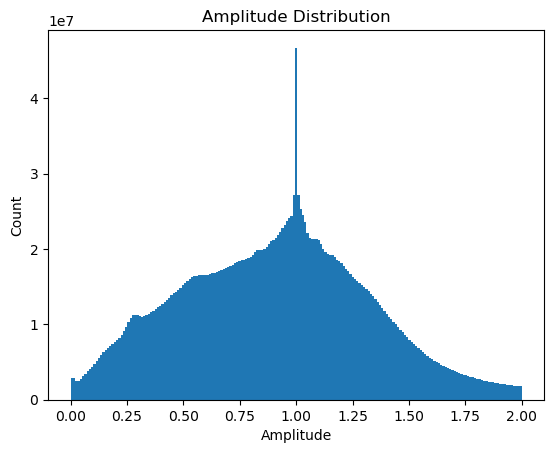

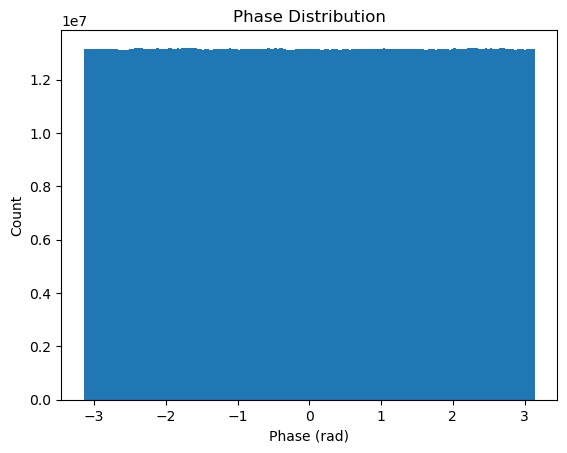

In [14]:
%time
# Define your bins once
amp_bins   = np.linspace(0, 2.0, 200)   # adjust max amplitude as needed
phase_bins = np.linspace(-np.pi, np.pi, 200)

# Initialize count accumulators
amp_counts   = np.zeros(len(amp_bins)-1, dtype=np.int64)
phase_counts = np.zeros(len(phase_bins)-1, dtype=np.int64)

chunk_size = 10_000
with h5py.File(FILE_PATH, 'r') as f:
    dset = f['X']   # shape (N_samples, sample_length, 2)
    N = dset.shape[0]
    for start in range(0, N, chunk_size):
        stop = min(start+chunk_size, N)
        # read one chunk
        data_chunk = dset[start:stop]                   # float32 shape (M, L, 2)
        complex_chunk = data_chunk[...,0] + 1j*data_chunk[...,1]
        amps   = np.abs(complex_chunk).ravel()
        phases = np.angle(complex_chunk).ravel()
        # update histograms
        amp_counts  += np.histogram(amps,   bins=amp_bins)[0]
        phase_counts+= np.histogram(phases, bins=phase_bins)[0]

# Plot at the end
plt.figure()
plt.bar((amp_bins[:-1]+amp_bins[1:])/2, amp_counts, width=np.diff(amp_bins))
plt.title("Amplitude Distribution")
plt.xlabel("Amplitude"); plt.ylabel("Count")
plt.show()

plt.figure()
plt.bar((phase_bins[:-1]+phase_bins[1:])/2, phase_counts, width=np.diff(phase_bins))
plt.title("Phase Distribution")
plt.xlabel("Phase (rad)"); plt.ylabel("Count")
plt.show()

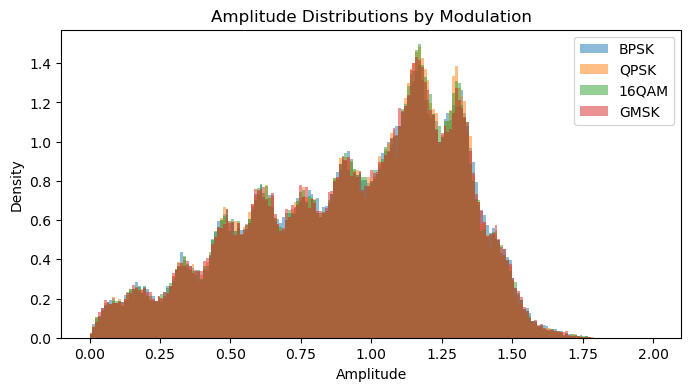

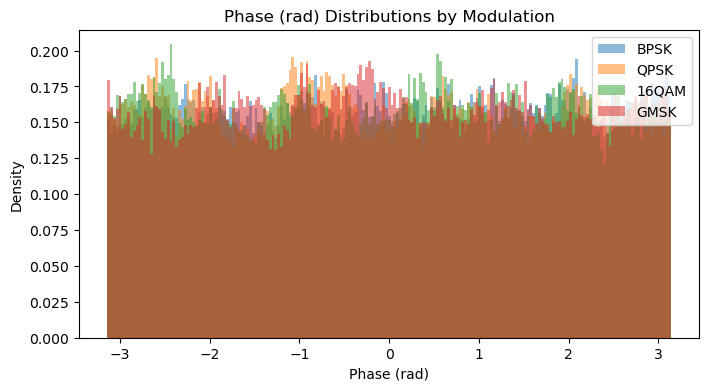

In [15]:

mods = ["BPSK","QPSK","16QAM","GMSK"]      # pick 3–5
for stat, bins, title in [
    ("amplitude", amp_bins, "Amplitude"),
    ("phase",     phase_bins, "Phase (rad)")
]:
    plt.figure(figsize=(8,4))
    for mod in mods:
        idx = df[df["mod"]==mod].index
        data = (amps if stat=="amplitude" else phases)[idx]
        plt.hist(data, bins=bins, alpha=0.5, label=mod, density=True)
    plt.title(f"{title} Distributions by Modulation")
    plt.xlabel(title); plt.ylabel("Density")
    plt.legend()
    plt.show()


In [16]:
import scipy.stats as stats
rows = []
for mod in fixed_classes:
    idx = df[df["mod"]==mod].index
    a = amps[idx]
    p = phases[idx]
    rows.append({
      "mod": mod,
      "mean_amp": np.mean(a),
      "std_amp":  np.std(a),
      "skew_amp": stats.skew(a.ravel()),
      "mean_ph":  stats.circmean(p.ravel(), high=np.pi, low=-np.pi),
      "var_ph":   stats.circvar(p.ravel(),  high=np.pi, low=-np.pi),
    })
stats_df = pd.DataFrame(rows).set_index("mod")
print(stats_df)


           mean_amp   std_amp  skew_amp   mean_ph    var_ph
mod                                                        
OOK        0.934721  0.360869 -0.476015 -3.110157  0.985733
4ASK       0.931077  0.365270 -0.454693  0.220834  0.989617
8ASK       0.934482  0.364055 -0.465047 -0.718243  0.985702
BPSK       0.934503  0.364399 -0.460342  1.663437  0.991386
QPSK       0.936763  0.360874 -0.488440 -1.620722  0.990953
8PSK       0.933154  0.364330 -0.458142 -0.341495  0.993071
16PSK      0.935026  0.365191 -0.456507  2.420280  0.988511
32PSK      0.934166  0.363641 -0.471810 -0.094032  0.991966
16APSK     0.935604  0.361071 -0.481809  1.102213  0.993048
32APSK     0.933929  0.363484 -0.467125 -0.647142  0.992077
64APSK     0.933593  0.362045 -0.471833 -1.423570  0.991595
128APSK    0.935660  0.363007 -0.470735  0.704879  0.989400
16QAM      0.935402  0.361760 -0.475370  2.189091  0.994756
32QAM      0.934833  0.363256 -0.469438 -0.898389  0.993895
64QAM      0.934808  0.364050 -0.464896 

### Now Let's focus on one SNR 

In [21]:

def extract_features(complex_samples):
    """
    complex_samples: 1D array of length L, one full I/Q chunk.
    Returns: [mean_amp, std_amp, circmean_phase, circvar_phase]
    """
    a = np.abs(complex_samples)
    p = np.angle(complex_samples)
    return [
        np.mean(a),
        np.std(a),
        stats.circmean(p, high=np.pi, low=-np.pi),
        stats.circvar(p,  high=np.pi, low=-np.pi),
    ]


In [23]:
high_snr  = 30

# Load labels & SNRs once
with h5py.File(FILE_PATH,'r') as f:
    Y_onehot = f['Y'][:]        # shape (N, M)
    Z_arr     = f['Z'][:].flatten()  # shape (N,)
fixed_classes = json.load(open(JSON_PATH))
mod_indices   = np.argmax(Y_onehot, axis=1)

# Prepare lists
features = []
labels   = []

chunk_size = 10_000
with h5py.File(FILE_PATH,'r') as f:
    X_dset = f['X']             # shape (N, L, 2)
    N = X_dset.shape[0]
    for start in range(0, N, chunk_size):
        stop = min(start+chunk_size, N)
        snr_chunk = Z_arr[start:stop]
        idxs = np.where(snr_chunk == high_snr)[0]
        if len(idxs)==0:
            continue
        X_chunk = X_dset[start:stop]   # (C, L, 2)
        for i in idxs:
            samp = X_chunk[i,:,0] + 1j*X_chunk[i,:,1]
            feat = extract_features(samp)
            features.append(feat)
            labels.append(fixed_classes[mod_indices[start + i]])


In [24]:
X_feat = np.array(features)   # shape (N_high_snr, 4)
y_lbl   = np.array(labels)     # shape (N_high_snr,)

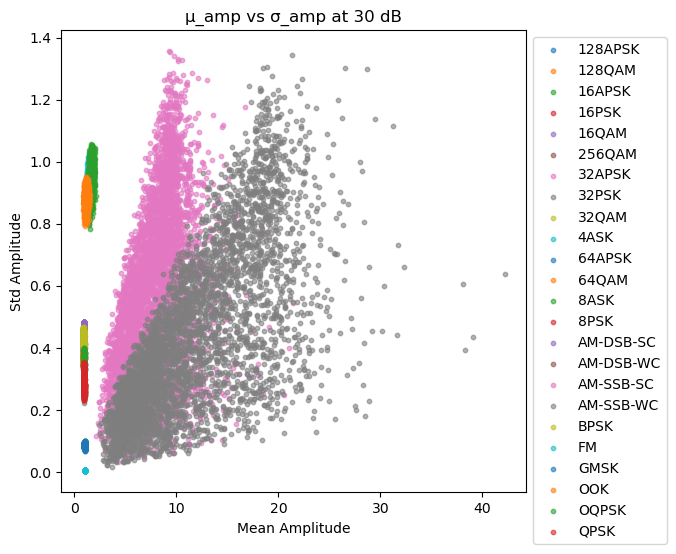

/home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

     128APSK       0.15      0.14      0.14      1228
      128QAM       0.14      0.07      0.09      1229
      16APSK       0.41      0.58      0.48      1229
       16PSK       0.26      0.38      0.31      1229
       16QAM       0.14      0.05      0.07      1229
      256QAM       0.13      0.08      0.10      1229
      32APSK       0.20      0.34      0.25      1229
       32PSK       0.12      0.01      0.02      1229
       32QAM       0.15      0.14      0.14      1228
        4ASK       0.80      0.76      0.78      1229
      64APSK       0.05      0.00      0.00      1229
       64QAM       0.12      0.07      0.09      1229
        8ASK       0.81      0.86      0.83      1229
        8PSK       0.26      0.35      0.30      1229
   AM-DSB-SC       0.49      0.88      0.63      1229
   AM-DSB-WC       0.26      0.26      0.26      1229
   AM-SSB-SC       0.78      0.77      0.77      1228
   AM-SSB-WC       0.77    

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics       import classification_report

# Scatter mean_amp vs std_amp
plt.figure(figsize=(6,6))
for mod in np.unique(y_lbl):
    sel = y_lbl == mod
    plt.scatter(X_feat[sel,0], X_feat[sel,1], label=mod, alpha=0.6, s=10)
plt.xlabel("Mean Amplitude")
plt.ylabel("Std Amplitude")
plt.legend(bbox_to_anchor=(1,1))
plt.title(f"μ_amp vs σ_amp at {high_snr} dB")
plt.show()

# Baseline classifier
X_tr, X_te, y_tr, y_te = train_test_split(
    X_feat, y_lbl, test_size=0.3, stratify=y_lbl, random_state=42
)
clf = LogisticRegression(multi_class='multinomial', max_iter=1000)
clf.fit(X_tr, y_tr)
print(classification_report(y_te, clf.predict(X_te)))

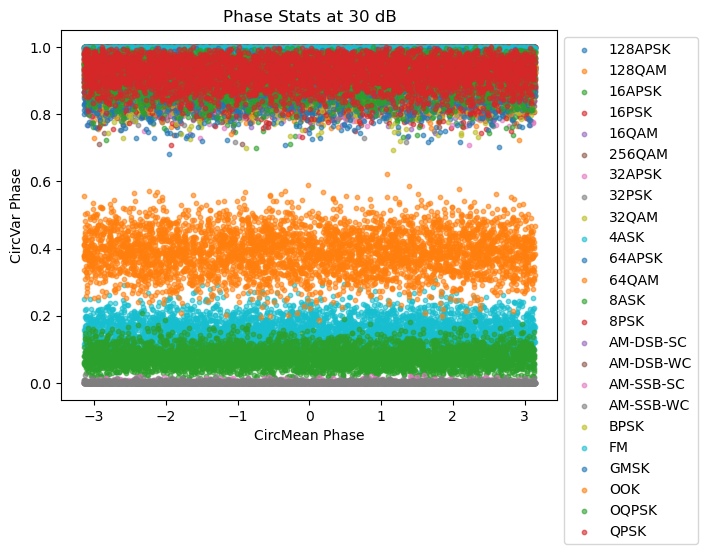

In [26]:
plt.figure()
for mod in np.unique(y_lbl):
    sel = y_lbl==mod
    plt.scatter(X_feat[sel,2], X_feat[sel,3], label=mod, s=10, alpha=0.6)
plt.xlabel("CircMean Phase"); plt.ylabel("CircVar Phase")
plt.legend(bbox_to_anchor=(1,1))
plt.title("Phase Stats at 30 dB")
plt.show()

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics       import classification_report
import numpy as np

# Suppose `features` is your list of [µ_amp, σ_amp, µ_phase, var_phase]
# and `labels` is your corresponding list of modulation strings.

X = np.array(features)    # shape (N_high_snr, 4)
y = np.array(labels)

# Stratified split to keep class proportions
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train on all four features
clf = LogisticRegression(multi_class='multinomial', max_iter=1000)
clf.fit(X_tr, y_tr)

# Evaluate
y_pred = clf.predict(X_te)
print(classification_report(y_te, y_pred))


/home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

     128APSK       0.15      0.14      0.14      1228
      128QAM       0.14      0.07      0.09      1229
      16APSK       0.41      0.58      0.48      1229
       16PSK       0.26      0.38      0.31      1229
       16QAM       0.14      0.05      0.07      1229
      256QAM       0.13      0.08      0.10      1229
      32APSK       0.20      0.34      0.25      1229
       32PSK       0.12      0.01      0.02      1229
       32QAM       0.15      0.14      0.14      1228
        4ASK       0.80      0.76      0.78      1229
      64APSK       0.05      0.00      0.00      1229
       64QAM       0.12      0.07      0.09      1229
        8ASK       0.81      0.86      0.83      1229
        8PSK       0.26      0.35      0.30      1229
   AM-DSB-SC       0.49      0.88      0.63      1229
   AM-DSB-WC       0.26      0.26      0.26      1229
   AM-SSB-SC       0.78      0.77      0.77      1228
   AM-SSB-WC       0.77    

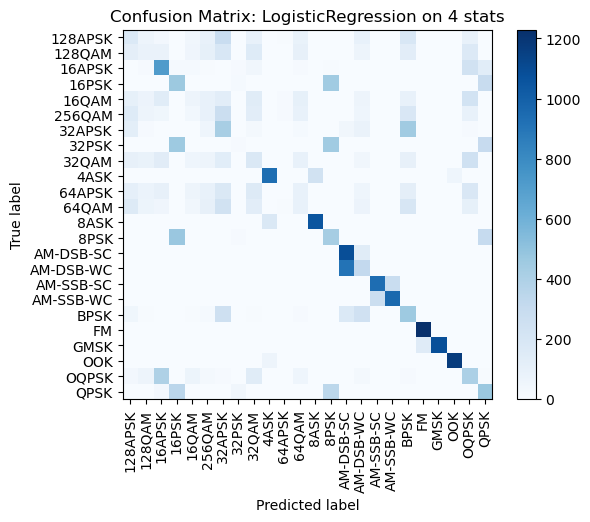

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_te, y_te, 
    include_values=False,  # just colors
    xticks_rotation=90,
    cmap="Blues"
)
plt.title("Confusion Matrix: LogisticRegression on 4 stats")
plt.show()


In [29]:
from scipy.stats import skew, kurtosis

def extract_features2(cplx):
    a = np.abs(cplx)
    p = np.angle(cplx)
    return [
        np.mean(a), np.std(a),
        skew(a), kurtosis(a),
        stats.circmean(p, high=np.pi, low=-np.pi),
        stats.circvar(p,  high=np.pi, low=-np.pi),
    ]


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf.fit(X_tr, y_tr)
print(classification_report(y_te, rf.predict(X_te)))

              precision    recall  f1-score   support

     128APSK       0.16      0.12      0.13      1228
      128QAM       0.12      0.12      0.12      1229
      16APSK       0.45      0.76      0.57      1229
       16PSK       0.30      0.36      0.32      1229
       16QAM       0.14      0.09      0.11      1229
      256QAM       0.15      0.10      0.12      1229
      32APSK       0.31      0.34      0.32      1229
       32PSK       0.26      0.21      0.23      1229
       32QAM       0.15      0.17      0.16      1228
        4ASK       0.86      0.82      0.84      1229
      64APSK       0.13      0.03      0.05      1229
       64QAM       0.11      0.11      0.11      1229
        8ASK       0.84      0.88      0.86      1229
        8PSK       0.29      0.27      0.28      1229
   AM-DSB-SC       0.97      0.54      0.69      1229
   AM-DSB-WC       0.65      0.96      0.78      1229
   AM-SSB-SC       0.97      0.82      0.89      1228
   AM-SSB-WC       0.84    